---
# 특강 프로젝트
---

- 예시로 cartpole, mountaincar, acrobot 도전으로 bipedalwalker or car-racing
dqn, pg, actor-critic 까지 돌리고 분석(plot, board)

- ppt 순서는 강화학습 소개 - gym 소개 - 실습 별 환경 및 이론 소개 - 실습

- correlation, non stationary target 때문에 simple 한 q - learning 은 잘 안됨

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import gym
import tensorflow as tf
import random
import numpy as np
from collections import deque
import dqn

In [2]:
import sys
#sys.path.append('C:\\Users\\itfor\\Anaconda3\\Lib\\site-packages')

---
# simple Q learning
---

In [3]:
env = gym.make('CartPole-v1')

In [4]:
size_s = env.observation_space.shape[0]
size_w1 = 8
size_w2 = 20
size_w3 = 10
size_out = env.action_space.n
lr = .1 ##Learning rate
total_episode = 500
epsilon = .1
gamma = .95 ##discount factor

STATE_IN = tf.placeholder(tf.float32, shape=[None, size_s])
targetQ = tf.placeholder(tf.float32, shape=[None, size_out])
W_1 = tf.Variable(tf.random_normal([size_s, size_w1]))
W_2 = tf.Variable(tf.random_normal([size_w1, size_w2]))
W_3 = tf.Variable(tf.random_normal([size_w2, size_w3]))
OUT = tf.Variable(tf.random_normal([size_w3, size_out]))

In [5]:
L_1 = (tf.matmul(STATE_IN, W_1))
L_2 = (tf.matmul(L_1, W_2))
L_3 = tf.matmul(L_2, W_3)
Qout = (tf.matmul(L_3, OUT))
loss = tf.reduce_mean(tf.square(Qout - targetQ))
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

In [6]:
# 그래프 그리는 함수
def make_graph(x, y):
    plt.ion()
    fig = plt.figure()
    sp = fig.add_subplot(111)
    plt.xlim([0, 2000])
    plt.ylim([0, 2000])
    line, = plt.plot(x, y, 'b')
    sp.set_xlabel('episode')
    sp.set_ylabel('reward')
    return fig, sp, line

<IPython.core.display.Javascript object>


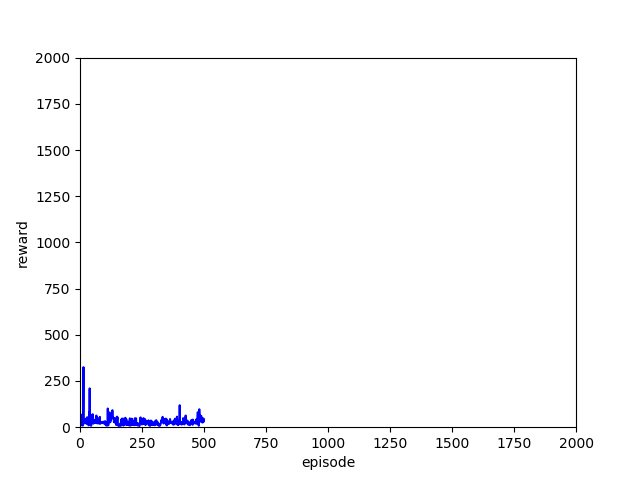

episode 1, score : 11 
episode 2, score : 10 
episode 3, score : 14 
episode 4, score : 14 
episode 5, score : 18 
episode 6, score : 24 
episode 7, score : 68 
episode 8, score : 12 
episode 9, score : 15 
episode 10, score : 9 
episode 11, score : 9 
episode 12, score : 10 
episode 13, score : 132 
episode 14, score : 325 
episode 15, score : 19 
episode 16, score : 34 
episode 17, score : 32 
episode 18, score : 36 
episode 19, score : 24 
episode 20, score : 24 
episode 21, score : 32 
episode 22, score : 37 
episode 23, score : 46 
episode 24, score : 32 
episode 25, score : 27 
episode 26, score : 18 
episode 27, score : 32 
episode 28, score : 30 
episode 29, score : 54 
episode 30, score : 45 
episode 31, score : 27 
episode 32, score : 38 
episode 33, score : 26 
episode 34, score : 11 
episode 35, score : 10 
episode 36, score : 26 
episode 37, score : 83 
episode 38, score : 64 
episode 39, score : 210 
episode 40, score : 47 
episode 41, score : 50 
episode 42, score : 69 


episode 335, score : 30 
episode 336, score : 31 
episode 337, score : 20 
episode 338, score : 40 
episode 339, score : 43 
episode 340, score : 23 
episode 341, score : 39 
episode 342, score : 32 
episode 343, score : 35 
episode 344, score : 45 
episode 345, score : 24 
episode 346, score : 46 
episode 347, score : 35 
episode 348, score : 13 
episode 349, score : 43 
episode 350, score : 10 
episode 351, score : 10 
episode 352, score : 33 
episode 353, score : 26 
episode 354, score : 21 
episode 355, score : 18 
episode 356, score : 26 
episode 357, score : 31 
episode 358, score : 22 
episode 359, score : 19 
episode 360, score : 21 
episode 361, score : 21 
episode 362, score : 28 
episode 363, score : 44 
episode 364, score : 27 
episode 365, score : 25 
episode 366, score : 23 
episode 367, score : 27 
episode 368, score : 30 
episode 369, score : 25 
episode 370, score : 23 
episode 371, score : 21 
episode 372, score : 19 
episode 373, score : 28 
episode 374, score : 25 


In [7]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    state = env.reset()
    ep = 1
    step = 0
    total_reward = 0
    
     # 그래프 생성
    x_data = []
    y_data = []
    fig, sp, line = make_graph(x_data, y_data)
    
    while ep < total_episode:
        step += 1
        #env.render() 
        state = np.reshape(state, newshape=[1, size_s])
        Q_prev = sess.run(Qout, feed_dict={STATE_IN:state})
        
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_prev)
            
        new_state, r, d, _ = env.step(action)

        if d:
            # 그래프 그리기
            x_data.append(ep)
            y_data.append(step)

            line.set_xdata(x_data)
            line.set_ydata(y_data)
            fig.canvas.draw()
            
            target[0,action] = -100        # - 보상(벌) 을 주어서 그 액션은 하지 않도록 강화한다.
            epsilon = 1./((ep/50) + 10)
            print("episode {}, score : {} ".format(ep, step))
            step = 0
            ep += 1
            state = env.reset()
        else:
            new_state = np.reshape(new_state, newshape=[1, size_s])
            Q_cur = sess.run(Qout, feed_dict={STATE_IN:new_state})
            target = Q_prev
            target[0,action] = r + gamma*np.argmax(Q_cur)

            sess.run(optimizer, feed_dict={targetQ:target, STATE_IN:state})
            state = new_state
            
env.close()

---
# DQN
---

In [8]:
'''
target 네트워크를 복사하는 함수
''' 
def copy(*, dest_scope_name = 'target', src_scope_name = 'main') :
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars) :
        op_holder.append(dest_var.assign(src_var))
        
    return op_holder


In [9]:
'''
과거 경험 중 랜덤으로 몇 개 뽑아 학습한다.
'''
def replay_train(mainDQN, targetDQN, train_batch) :
    x_stack = np.empty(0).reshape(0, size_s)
    y_stack = np.empty(0).reshape(0, size_out)
    
    for state, action, reward, next_state, done in train_batch :
        Q = mainDQN.predict(state)
        
        if done :
            Q[0, action] = -100
        
        else :
            Q[0, action] = reward + gamma*np.max(targetDQN.predict(next_state))
        
        x_stack = np.vstack([x_stack, state])
        y_stack = np.vstack([y_stack, Q])
        
    return mainDQN.update(x_stack, y_stack)

<IPython.core.display.Javascript object>


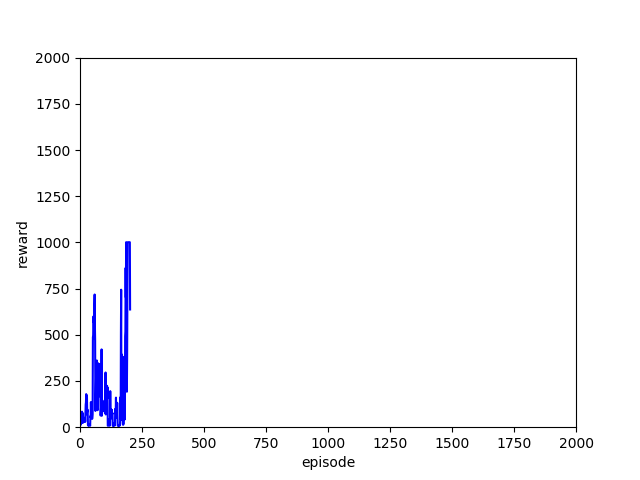

episode : 0, steps : 15
episode : 1, steps : 24
loss : 24.553766
episode : 2, steps : 11
episode : 3, steps : 55
episode : 4, steps : 25
episode : 5, steps : 38
episode : 6, steps : 44
episode : 7, steps : 22
episode : 8, steps : 84
episode : 9, steps : 35
episode : 10, steps : 78
episode : 11, steps : 71
loss : 0.92276573
episode : 12, steps : 24
episode : 13, steps : 28
episode : 14, steps : 47
episode : 15, steps : 28
episode : 16, steps : 35
episode : 17, steps : 35
episode : 18, steps : 34
episode : 19, steps : 30
episode : 20, steps : 51
episode : 21, steps : 30
loss : 0.66441834
episode : 22, steps : 74
episode : 23, steps : 123
episode : 24, steps : 134
episode : 25, steps : 179
episode : 26, steps : 70
episode : 27, steps : 123
episode : 28, steps : 171
episode : 29, steps : 82
episode : 30, steps : 87
episode : 31, steps : 94
loss : 0.93500537
episode : 32, steps : 10
episode : 33, steps : 10
episode : 34, steps : 11
episode : 35, steps : 8
episode : 36, steps : 9
episode : 3

In [10]:
total_episode = 1000
replay_buffer = deque()
ep = 0
step = 0
saver = tf.train.Saver()
save_file = 'C:\\Users\\김민수\\Documents\\GitHub\\RL\\vars\\cartpole_dqn'
mean_reward = deque()

with tf.Session() as sess:
      
    # 그래프 생성
    x_data = []
    y_data = []
    fig, sp, line = make_graph(x_data, y_data)
    
    '''
    네트워크 2 개 생성
    하나는 일시적으로 고정되어 학습의 목표가 되는 네트워크
    다른 하나는 실제 학습을 하는 네트워크
    '''
    mainDQN = dqn.DQN(sess, size_s, size_out, 8, 6, name='main')
    targetDQN = dqn.DQN(sess, size_s, size_out, 8, 6, name='target')
    
    tf.global_variables_initializer().run()
    copy_ops = copy(dest_scope_name='targetDQN', src_scope_name='mainDQN')
    sess.run(copy_ops)
    
    state = env.reset()
    
    for episode in range(total_episode) :
        e = 1. / ((episode / 10) + 1)    # 점점 감소하는 explore 
        done = False
        step_count = 0
        state = env.reset()
        
        
        while not done :
             
            # 액션 선택
            if np.random.rand(1) < e :
                action = env.action_space.sample()
            else :
                action = np.argmax(mainDQN.predict(state))
                    
            next_state, reward, done, _ = env.step(action)
                
            if done : 
                reward = -100
                
                
            # 학습하지않고 임시메모리에 저장한다.
            replay_buffer.append((state, action, reward, next_state, done))
            if(len(replay_buffer) > 50000) :
                replay_buffer.popleft()
             
            state = next_state
            step_count += 1
            
            if(step_count > 1000) :
                break
        
         # 그래프 그리기
        x_data.append(episode)
        y_data.append(step_count)

        line.set_xdata(x_data)
        line.set_ydata(y_data)
        fig.canvas.draw()
        
        print ('episode : {}, steps : {}'.format(episode, step_count))
                
        '''
        파라미터 로컬에 저장.
        '''
        if(len(mean_reward) < 10):
            mean_reward.append(step_count)
        else:
            mean_reward.popleft()
            if(np.mean(mean_reward) > 800):
                saver.save(sess, save_file)
                break
            
                
        # 10 회의 에피소드가 끝나면 임시메모리에서 과거 데이터를 랜덤으로 뽑아 학습한다.
        if(episode % 10 == 1) :
            for _ in range(50) :
                minibacth = random.sample(replay_buffer, 10)
                loss, _ = replay_train(mainDQN, targetDQN, minibacth)
                        
            print('loss :', loss)
            sess.run(copy_ops)   # 목표가 되는 네트워크를 업데이트한다.
                    
    env.close()

In [ ]:
with tf.Session() as sess:
    ep = 0
    step = 0
    state = env.reset()
    saver.restore(sess, save_file)
    
    while True:
        done = False
        
        while not done:
            env.render()
            step += 1
            state = np.reshape(state, [1, 4])
            pi = sess.run(L_out, feed_dict={STATE_IN:state})
            action = np.argmax(pi)
            new_state, r, d, _ = env.step(action)
            state = new_state
            
            if d:
                ep += 1
                print(ep, step)
                step = 0
                done = True
                state = env.reset()
env.close()